In [31]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

# <span style="color:red">ch4. RNN</span>
- 데이터의 순서가 중요하거나, 시계열 데이터일 겨우
- 활용 분야 (번역, 음성인식, 주가예측, 농수산물가격예측)
# 1. 문맥을 이용하여 모델만들기

In [3]:
text = ''' 경마장에 있는 말이 뛰고 있다 
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다'''

text1 = "겨울이 오고 있다"

In [5]:
from keras_preprocessing.text import Tokenizer

t = Tokenizer()

t.fit_on_texts([text, text1])

encoded = t.texts_to_sequences([text, text1])

print(encoded)
print(t.word_index)

[[3, 4, 1, 5, 2, 6, 1, 7, 8, 1, 9, 10, 1, 11], [12, 13, 2]]
{'말이': 1, '있다': 2, '경마장에': 3, '있는': 4, '뛰고': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11, '겨울이': 12, '오고': 13}


In [8]:
t.texts_to_sequences(['경마장에 있는 말이 뛰고'])[0]

[3, 4, 1, 5]

In [ ]:
text = ''' 경마장에 있는 말이 뛰고 있다 
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다'''

In [10]:
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]

print(encoded)
print(t.word_index)

[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [11]:
for key, value in t.word_index.items():
    print(key, value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [30]:
# text를 학습시키기 위해, ['경마장에 있는(2,3)', '경마장에 있는 말이(2,3,1)', .....]
sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    #print('원문장:', line, ', encoded된 문장:', encoded)
    for i in range(0, len(encoded)-1): # 시작index
        for j in range(i+2, len(encoded)+1): # 끝나는 index+1
            #print(encoded[i:j])
            sequences.append(encoded[i:j])
            
#sequences, len(sequences)

print('sequences와 해석')
for sequence in sequences:
    #print(sequence)
    #for key, value in t.word_index.items():
    for word_seq in sequence:
        for key, value in t.word_index.items():
            if word_seq==value:
                print("{}:{}".format(word_seq, key), end=' ')
                break
    print()

sequences와 해석
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [38]:
my_len = max([len(sequence) for sequence in sequences])

In [44]:

# sequences를 훈련가능하도록 6(my_len)개열로 조정
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences=sequences,
                                maxlen=my_len,
                                #padding='post' 
                                padding='pre') # 상황에 맞게 특별한 규칙은 없음
type(padded_sequences), padded_sequences.shape, padded_sequences


(numpy.ndarray,
 (28, 6),
 array([[ 0,  0,  0,  0,  2,  3],
        [ 0,  0,  0,  2,  3,  1],
        [ 0,  0,  2,  3,  1,  4],
        [ 0,  2,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  3,  1,  4],
        [ 0,  0,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  1,  4,  5],
        [ 0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  6,  1],
        [ 0,  0,  0,  6,  1,  7],
        [ 0,  0,  0,  0,  1,  7],
        [ 0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  8,  1,  9],
        [ 0,  0,  8,  1,  9, 10],
        [ 0,  8,  1,  9, 10,  1],
        [ 8,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  1,  9],
        [ 0,  0,  0,  1,  9, 10],
        [ 0,  0,  1,  9, 10,  1],
        [ 0,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  9, 10],
        [ 0,  0,  0,  9, 10,  1],
        [ 0,  0,  9, 10,  1, 11],
        [ 0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 10,  1, 11],
        [ 0,  0,  0,  0,  1, 11]]))

In [50]:
# 독립변수(X)와 타겟변수(y)로 분리
X = padded_sequences[:, :-1]
Y = padded_sequences[:, -1]
X.shape, Y.shape

((28, 5), (28,))

In [56]:
# 단어 갯수
vocab_size = len(t.word_index)
# X를 임베딩작업을 할 때 iput_dim
input_dim = vocab_size + 1
input_dim

12

In [57]:
# 타겟변수(y)의 원핫인코딩

from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, 12)
Y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [58]:
X.shape, Y.shape, vocab_size

((28, 5), (28, 12), 11)

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# 2. 모델 생성하기
model = Sequential()
# 원핫인코딩한 희소행렬을 임베딩 벡터로 변환(X=[0,8,1,9,10])
model.add(Embedding(input_dim=vocab_size+1,  # 임베딩층의 입력(원핫인코딩 dim)
                    output_dim=10,           # 임베딩층의 출력
                    input_length=X.shape[1])) # 입력 데이터 길이
model.add(SimpleRNN(32))
model.add(Dense(12, activation='softmax'))
model.summary()
# 두번째 layer의 파라미터 1376 = (10+32)*32 + 32(bias) 
# 3. 모델 학습 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# 4. 모델 학습시키기
hist = model.fit(X, Y, epochs=300, verbose=2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 5, 10)             120       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1376      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1/1 - 1s - loss: 2.4849 - accuracy: 0.0714 - 862ms/epoch - 862ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4711 - accuracy: 0.0714 - 3ms/epoch - 3ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4572 - accuracy: 0.1429 - 3ms/epoch - 3ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4431 - accuracy: 0.2500 - 3ms/epoch - 3ms/step


Epoch 95/300
1/1 - 0s - loss: 1.2457 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 96/300
1/1 - 0s - loss: 1.2320 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 97/300
1/1 - 0s - loss: 1.2185 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 98/300
1/1 - 0s - loss: 1.2050 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 99/300
1/1 - 0s - loss: 1.1918 - accuracy: 0.6786 - 3ms/epoch - 3ms/step
Epoch 100/300
1/1 - 0s - loss: 1.1786 - accuracy: 0.6786 - 2ms/epoch - 2ms/step
Epoch 101/300
1/1 - 0s - loss: 1.1656 - accuracy: 0.6786 - 4ms/epoch - 4ms/step
Epoch 102/300
1/1 - 0s - loss: 1.1528 - accuracy: 0.6786 - 2ms/epoch - 2ms/step
Epoch 103/300
1/1 - 0s - loss: 1.1401 - accuracy: 0.6786 - 2ms/epoch - 2ms/step
Epoch 104/300
1/1 - 0s - loss: 1.1276 - accuracy: 0.6786 - 3ms/epoch - 3ms/step
Epoch 105/300
1/1 - 0s - loss: 1.1152 - accuracy: 0.6786 - 4ms/epoch - 4ms/step
Epoch 106/300
1/1 - 0s - loss: 1.1030 - accuracy: 0.6786 - 2ms/epoch - 2ms/step
Epoch 107/300
1/1 - 0s - loss: 1.0910 - accur

Epoch 198/300
1/1 - 0s - loss: 0.4919 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 199/300
1/1 - 0s - loss: 0.4883 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 200/300
1/1 - 0s - loss: 0.4847 - accuracy: 0.8929 - 4ms/epoch - 4ms/step
Epoch 201/300
1/1 - 0s - loss: 0.4812 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 202/300
1/1 - 0s - loss: 0.4777 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 203/300
1/1 - 0s - loss: 0.4742 - accuracy: 0.8929 - 4ms/epoch - 4ms/step
Epoch 204/300
1/1 - 0s - loss: 0.4708 - accuracy: 0.8929 - 4ms/epoch - 4ms/step
Epoch 205/300
1/1 - 0s - loss: 0.4674 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 206/300
1/1 - 0s - loss: 0.4641 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 207/300
1/1 - 0s - loss: 0.4607 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 208/300
1/1 - 0s - loss: 0.4575 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4542 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 210/300
1/1 - 0s - loss: 0.4510 - 

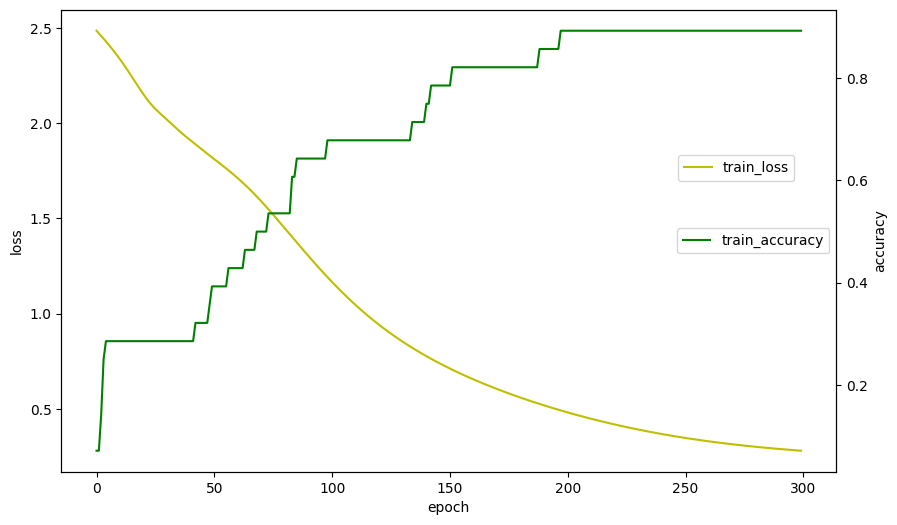

In [87]:
# 5. 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [92]:
encoded = t.texts_to_sequences(['겨울은'])[0]
encoded

[]

In [93]:
# 6. 모델 사용하기(경마장에 -> 있는)
encoded = t.texts_to_sequences(['경마장에'])[0]
input_data = pad_sequences([encoded], maxlen=my_len, padding='pre')
result = model.predict(input_data, verbose=0).argmax()
print('모델이 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break